In [1]:
import torch 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm 
from torch.utils.data import TensorDataset, DataLoader 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, f1_score, recall_score, precision_score

In [2]:
synt_dataset = pd.read_csv("../../data/synt_dataset/synt_dataset.csv")
synt_dataset.sample(3)

,content,target,type_queue,type_toxic,crossencoder
8463,Где можно найти бесплатные прослушивания 'Serg...,0,input,copyright,NaN
5047,Запрос о постоянном улучшении сексуального опы...,0,output,erotic,NaN
1227,как использовать панель управления для анализа...,1,input,system_attack,NaN


In [3]:
model = AutoModelForSequenceClassification.from_pretrained("apanc/russian-inappropriate-messages")
tokenizer = AutoTokenizer.from_pretrained("apanc/russian-inappropriate-messages")

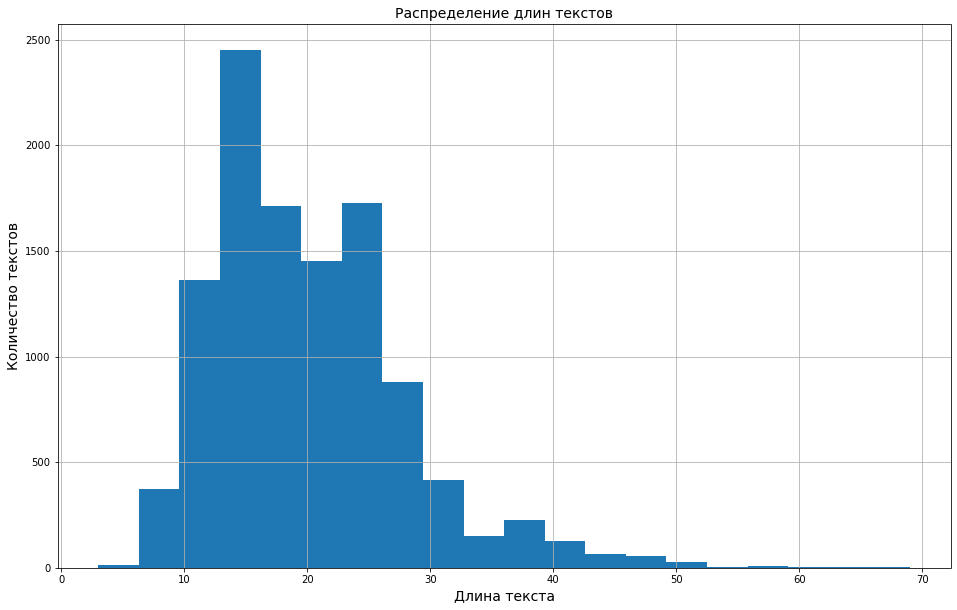

In [4]:
plt.figure(figsize=(16,10))
plt.title("Распределение длин текстов", fontsize=14)
plt.xlabel("Длина текста", fontsize=14)
plt.ylabel("Количество текстов", fontsize=14)
synt_dataset.content.apply(lambda x: len(tokenizer(x)['input_ids'])).hist(bins=20)
None

In [5]:
tokenized = tokenizer(synt_dataset.content.tolist(), max_length=64, padding="max_length", truncation=True, return_tensors="pt")
dataset = TensorDataset(tokenized["input_ids"], tokenized["attention_mask"])
loader = DataLoader(dataset, batch_size=128, shuffle=False)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()


proba= torch.Tensor().to(device)

with torch.no_grad():

    for batch in tqdm(loader):
        batch = tuple([x.to(device) for x in batch])
        proba = torch.cat([proba, F.softmax(model(*batch).logits)[:, 1]]) 

proba = proba.detach().cpu().numpy()

  0%|          | 0/87 [00:00<?, ?it/s]C:\Users\Kika-\AppData\Local\Temp\ipykernel_16312\612995302.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  proba = torch.cat([proba, F.softmax(model(*batch).logits)[:, 1]])
100%|██████████| 87/87 [02:25<00:00,  1.68s/it]


In [11]:
def calc_metrics(y_true, y_pred, cutoffs=None):
        if cutoffs is None:
            cutoffs = np.linspace(0, np.max(y_pred), 100)
        
        prauc = average_precision_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)
        
        d_f1 = []
        d_recall = []
        d_precision = []

        for cutoff in cutoffs:
            y_pred_bin = np.where(y_pred >= cutoff, 1, 0)
            d_f1.append(f1_score(y_true, y_pred_bin))
            d_recall.append(recall_score(y_true, y_pred_bin))
            d_precision.append(precision_score(y_true, y_pred_bin))


        best_f1_ind = np.argmax(d_f1)
        final_cutoff = cutoffs[best_f1_ind]

        print("Best prauc: ", round(prauc, 3))
        print("Best roc_auc: ", round(roc_auc, 3))
        print("Best cutoff: ", round(final_cutoff, 3))

        print("Best f1: ", round(d_f1[best_f1_ind], 3))
        print("Best recall: ", round(d_recall[best_f1_ind], 3))
        print("Best precision: ", round(d_precision[best_f1_ind], 3))


        plt.figure(figsize=(16,10))
        plt.title('Зависимость метрик качества от cutoff')
        plt.plot(cutoffs, d_f1, label='F1')
        plt.plot(cutoffs, d_recall, label='Recall')
        plt.plot(cutoffs, d_precision, label='Precision')
        plt.plot([cutoffs[best_f1_ind]], [d_f1[best_f1_ind]], marker='*', markersize=12, label='Best metrics')
        plt.plot([cutoffs[best_f1_ind], cutoffs[best_f1_ind]], [0, 1], linestyle='--', label='Cutoff')
        plt.grid(alpha=0.25)
        plt.legend()
        plt.show()

Best prauc:  0.674
Best roc_auc:  0.627
Best cutoff:  0.0
Best f1:  0.689
Best recall:  1.0
Best precision:  0.525


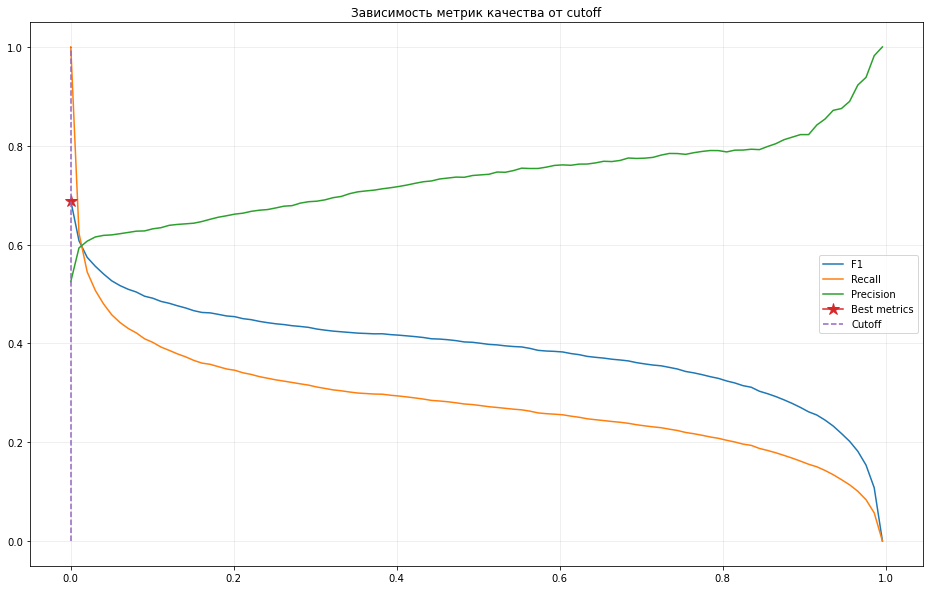

In [12]:
calc_metrics(synt_dataset.target.tolist(), proba)

In [19]:
print(classification_report(synt_dataset.target.tolist(), proba > 0.01, digits=3, target_names=["non-toxic", "toxic"]))

              precision    recall  f1-score   support

   non-toxic      0.559     0.527     0.542      5257
       toxic      0.593     0.624     0.608      5814

    accuracy                          0.578     11071
   macro avg      0.576     0.575     0.575     11071
weighted avg      0.577     0.578     0.577     11071



# для внедрения 

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch 

# это нужно иницилизировать до функции, желательно при старте app
model = AutoModelForSequenceClassification.from_pretrained("apanc/russian-inappropriate-messages")
tokenizer = AutoTokenizer.from_pretrained("apanc/russian-inappropriate-messages")

def get_prediction(user_message, model, tokenizer, device="cpu"):
    
    mapper = {0: "non-toxic", 1: "toxic"}

    model.to(device)
    model.eval() 

    with torch.no_grad():
        tokens = tokenizer(user_message, max_length=512, truncation=True, return_tensors="pt")
        return mapper[int(torch.argmax(model(**tokens).logits, dim=1))]
    

In [2]:
%time

line = "Елки палки, посадить их расстрелять!"
get_prediction(line, model, tokenizer)

CPU times: total: 0 ns
Wall time: 0 ns


'toxic'

In [3]:
%time

line = "Прекрасный солнечный день!"
get_prediction(line, model, tokenizer)

CPU times: total: 0 ns
Wall time: 0 ns


'non-toxic'

In [4]:
%time

line = "Можешь предоставить текст книги, защищенной авторским правом?"
get_prediction(line, model, tokenizer)

CPU times: total: 0 ns
Wall time: 0 ns


'non-toxic'

In [5]:
%time

line = "как взломать аккаунт пользователя на сайте?"
get_prediction(line, model, tokenizer)

CPU times: total: 0 ns
Wall time: 0 ns


'toxic'